In [3]:
import pandas as pd

spam_collection = pd.read_csv("C:/Users/nrebe/Downloads/Spam Filter/SMSSpamCollection_original.csv",
    sep="\t",
    header=None,
    names=["label", "text"],
    encoding="utf-8"
)
spam_collection.head



<bound method NDFrame.head of      label                                               text
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...
...    ...                                                ...
5567  spam  This is the 2nd time we have tried 2 contact u...
5568   ham               Will ü b going to esplanade fr home?
5569   ham  Pity, * was in mood for that. So...any other s...
5570   ham  The guy did some bitching but I acted like i'd...
5571   ham                         Rofl. Its true to its name

[5572 rows x 2 columns]>

## Initial Statistics 

In [4]:
# Check dataset structure, data types and memory usage.
spam_collection.info()

# Summary of basic statistics (for text, only counts will appear).
spam_collection.describe(include="all")

# Count the number of spam vs. ham messages to understand class balance.
spam_collection["label"].value_counts()

# Check for missing values in any column.
spam_collection.isna().sum()

# Check for duplicate rows in the dataset.
spam_collection.duplicated().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


403

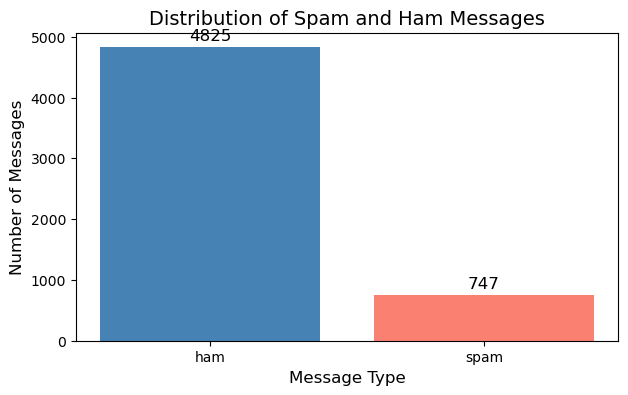

In [5]:
import matplotlib.pyplot as plt

# Count how many messages belong to each class
label_counts = spam_collection["label"].value_counts()

# Create a bar chart to visualize the class distribution
plt.figure(figsize=(7, 4))
bars = plt.bar(label_counts.index, label_counts.values, 
               color=["steelblue", "salmon"])

# Add title and axis labels
plt.title("Distribution of Spam and Ham Messages", fontsize=14)
plt.xlabel("Message Type", fontsize=12)
plt.ylabel("Number of Messages", fontsize=12)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.annotate(
        f'{height}',                       # text = height value
        xy=(bar.get_x() + bar.get_width()/2, height),  # position above bar
        xytext=(0, 3),                      # slight vertical offset
        textcoords="offset points",
        ha='center', 
        va='bottom',
        fontsize=12
    )

# Display the plot
plt.show()


## Comentário ao gráfico “Distribution of Spam and Ham Messages”

The bar chart shows the total number of **ham** (legitimate) and **spam** messages in the dataset. The distribution is highly imbalanced: out of **5,572 messages**, **4,825 are ham**, while only **747 are spam**.

This imbalance is a critical characteristic of the dataset. Although it reflects real-world messaging behavior—where legitimate messages are far more common than spam—it also introduces challenges for model training. A naïve model could achieve high accuracy simply by predicting *“ham”* for most messages, but it would fail to detect a substantial portion of spam.

For this reason, performance metrics such as **precision**, **recall**, and **F1-score** become more relevant than accuracy alone. Additionally, the imbalance supports the need for **adjustable classification thresholds**, allowing the service team to control the model’s sensitivity and reduce the risk of misclassifying important customer messages as spam.

### Analysis of Duplicate Messages

During the data quality assessment, we detected that the dataset contains **483 duplicated messages** out of a total of 5,572 entries. This represents approximately **8.66%** of the entire dataset. Since the SMS Spam Collection corpus was aggregated from multiple public sources, the presence of duplicates is expected and reflects the fact that some messages appear across several datasets


In [6]:
!pip install wordcloud



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


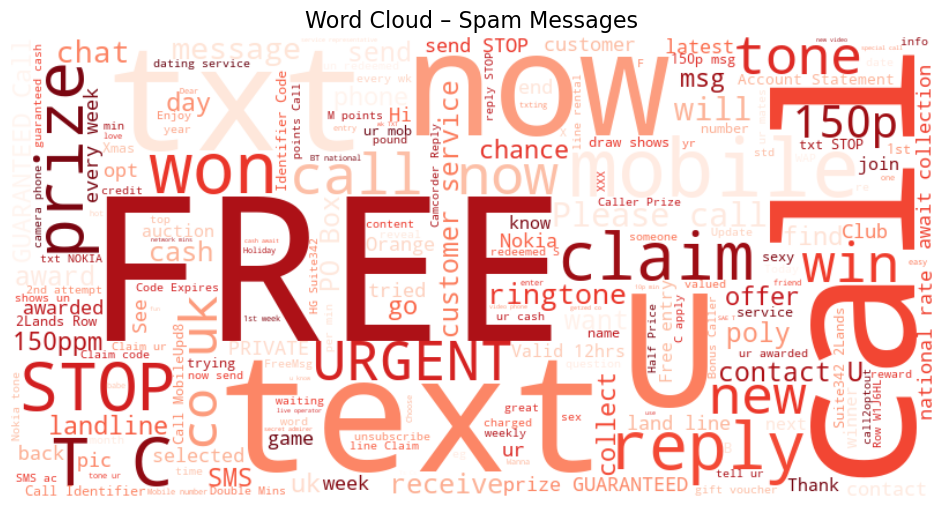

In [7]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filter only spam messages
spam_texts = spam_collection[spam_collection['label'] == 'spam']['text']

# Join all spam messages into one single large string
spam_string = " ".join(spam_texts)

# Generate the word cloud
spam_wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='Reds'  # red tones for spam
).generate(spam_string)

# Plot
plt.figure(figsize=(12, 6))
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud – Spam Messages", fontsize=16)
plt.show()


## Word Cloud (Spam Messages)

The spam word cloud shows that spam messages tend to use highly repetitive and attention-grabbing terms such as **“call”**, **“FREE”**, **“now”**, **“prize”**, **“mobile”**, and **“text”**. These words are typical of promotional or fraudulent content aimed at pressuring the user to respond quickly or claim an offer. The presence of many imperative verbs and financial terms reflects classic spam strategies designed to attract immediate action. This confirms that spam messages follow recognizable linguistic patterns, which is useful for feature extraction and model training.




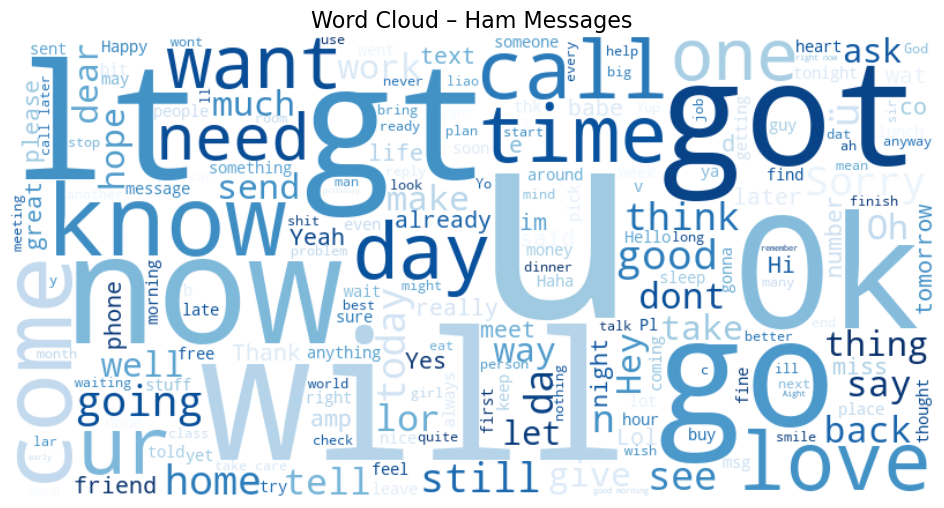

In [8]:
# Filter only ham messages
ham_texts = spam_collection[spam_collection['label'] == 'ham']['text']

# Join all ham messages into one single large string
ham_string = " ".join(ham_texts)

# Generate the word cloud
ham_wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='Blues'  # blue tones for legitimate messages
).generate(ham_string)

# Plot
plt.figure(figsize=(12, 6))
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud – Ham Messages", fontsize=16)
plt.show()


## Word Cloud (Ham Messages)

The ham word cloud reveals a very different linguistic profile. The most frequent words—such as **“ok”**, **“come”**, **“know”**, **“love”**, **“going”**, **“got”** and **“dear”**—reflect everyday, conversational language. These messages contain personal expressions, greetings, and informal communication between friends or family. Compared to spam, ham messages show a wider variety of contexts and emotional content, with fewer repeated keywords. This illustrates the challenges of distinguishing informal conversations from spam, especially when slang, abbreviations, or short phrases are involved.


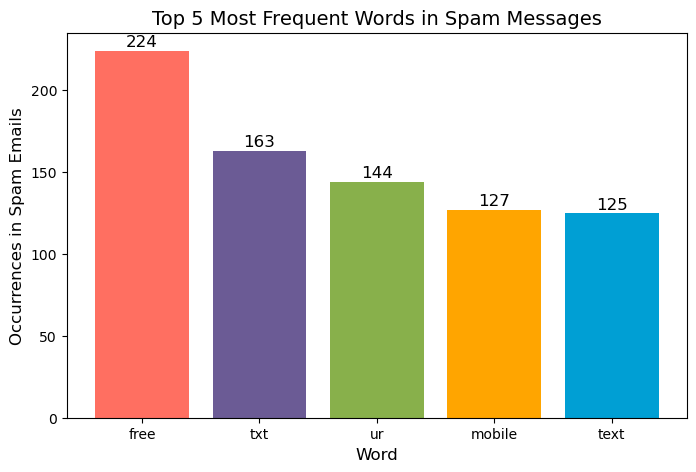

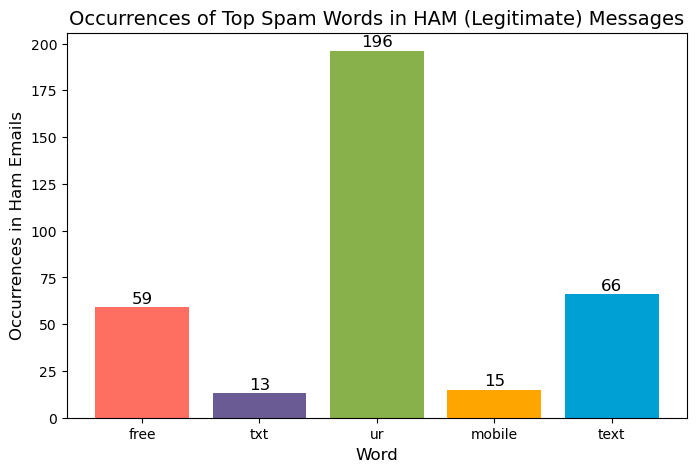

In [10]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# Filter spam messages only
spam_texts = spam_collection[spam_collection['label'] == 'spam']['text']

# Create a CountVectorizer to count word frequencies
vectorizer = CountVectorizer(stop_words='english')  # remove stopwords for clarity
X = vectorizer.fit_transform(spam_texts)

# Convert to DataFrame
word_counts = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Sum occurrences across all spam messages
total_counts = word_counts.sum(axis=0)

# Get the 5 most common words
top_words = total_counts.sort_values(ascending=False).head(5)

# Define different colors for each bar
colors = ["#FF6F61", "#6B5B95", "#88B04B", "#FFA500", "#009FD4"]

# Plotting
plt.figure(figsize=(8, 5))
bars = plt.bar(top_words.index, top_words.values, color=colors)

# Add labels above bars
for bar in bars:
    height = bar.get_height()
    plt.annotate(
        f"{int(height)}",
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 3),
        textcoords="offset points",
        ha='center',
        fontsize=12
    )

plt.title("Top 5 Most Frequent Words in Spam Messages", fontsize=14)
plt.xlabel("Word", fontsize=12)
plt.ylabel("Occurrences in Spam Emails", fontsize=12)
plt.show()



import matplotlib.pyplot as plt
import pandas as pd

# 1. Get the 5 top spam words (already computed from the previous step)
top_spam_words = list(top_words.index)

# 2. Filter HAM messages only
ham_texts = spam_collection[spam_collection['label'] == 'ham']['text']

# 3. Count how many HAM emails contain each of the spam top words
ham_counts = []
for word in top_spam_words:
    count = ham_texts.str.contains(rf"\b{word}\b", case=False, regex=True).sum()
    ham_counts.append(count)

ham_counts_series = pd.Series(ham_counts, index=top_spam_words)

# 4. Define colors for the bars
colors = ["#FF6F61", "#6B5B95", "#88B04B", "#FFA500", "#009FD4"]

# 5. Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(ham_counts_series.index, ham_counts_series.values, color=colors)

# Add labels above bars
for bar in bars:
    height = bar.get_height()
    plt.annotate(
        f"{int(height)}",
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 3),
        textcoords="offset points",
        ha='center',
        fontsize=12
    )

plt.title("Occurrences of Top Spam Words in HAM (Legitimate) Messages", fontsize=14)
plt.xlabel("Word", fontsize=12)
plt.ylabel("Occurrences in Ham Emails", fontsize=12)
plt.show()


## Analysis of the Top 5 Spam Words in SPAM vs HAM Messages

To better understand the linguistic patterns in the dataset, we identified the five most frequent words in spam messages and compared how often these same words occur in legitimate (ham) messages. This analysis provides insight into which terms are strong predictors of spam and which ones appear in both categories, increasing classification complexity.

### **Top 5 Most Frequent Words in Spam Messages**
The most common words in spam messages were:

- **free** (224 occurrences)
- **txt** (163 occurrences)
- **ur** (144 occurrences)
- **mobile** (127 occurrences)
- **text** (125 occurrences)

These words are typical indicators of promotional or fraudulent content. Terms such as *“free”*, *“txt”*, and *“mobile”* are strongly associated with contests, subscriptions, offers, or urgent calls to action. This demonstrates that spam messages follow clear, repetitive linguistic patterns.

### **Occurrences of These Words in HAM Messages**
When we analyze the same words in legitimate messages, we observe significant differences:

- **ur** appears in **196 ham messages** — even more than in spam.
- **text** appears in **66 ham messages**.
- **free** appears in **59 ham messages**.
- **mobile** appears in **15 ham messages**.
- **txt** appears in only **13 ham messages**.

This shows that some words commonly used in spam (such as *“txt”* and *“mobile”*) are strong discriminators, while others (*“ur”*, *“text”*, *“free”*) appear in a substantial number of legitimate messages.

### **Interpretation**
This comparison highlights two important insights:

1. **Spam has highly predictable patterns.**  
   Words such as *“free”*, *“txt”*, and *“mobile”* are strong indicators of spam and provide useful features for classification.

2. **Some words appear in both categories.**  
   Informal vocabulary such as *“ur”* and *“text”* appears frequently in ham messages, which means these terms cannot be used alone to determine whether a message is spam. This reinforces the need for more advanced text representation techniques (e.g., TF-IDF and n-grams).

### **Implications for Model Development**
- **Simple word-count features** are effective for detecting highly spam-specific words.  
- **TF-IDF** is needed to reduce the impact of common words shared across both categories.
- **N-grams** can capture context (e.g., *“free entry”*, *“text now”*), improving discrimination.
- **Adjustable classification thresholds** are essential because:
  - Some ham messages contain spam-like words → risk of false positives.
  - The service team must tune sensitivity depending on operational needs.

### **Conclusion**
This analysis demonstrates that while spam messages exhibit repetitive and predictable patterns, several key words overlap with legitimate communication. Therefore, a robust spam filter must combine word importance weighting, context modeling, and threshold control to achieve both accuracy and reliability.


In [11]:
import pandas as pd

# Character count per message
spam_collection["char_count"] = spam_collection["text"].str.len()

# Word count per message
spam_collection["word_count"] = spam_collection["text"].str.split().str.len()

# Average lengths by class (ham vs spam)
avg_lengths = spam_collection.groupby("label")[["char_count", "word_count"]].mean()

print(avg_lengths)


       char_count  word_count
label                        
ham     71.482487   14.310259
spam   138.670683   23.911647


In [12]:
import string
import re

# Function to count punctuation characters in a text
def count_punctuation(text):
    if pd.isna(text):
        return 0
    # Count any character in string.punctuation
    return sum(1 for ch in text if ch in string.punctuation)

# Apply to each message
spam_collection["punct_count"] = spam_collection["text"].apply(count_punctuation)

# Average punctuation count by class
avg_punct = spam_collection.groupby("label")["punct_count"].mean()

print(avg_punct)


label
ham     3.939896
spam    5.712182
Name: punct_count, dtype: float64


In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# TF-IDF vectorization on the full corpus
vectorizer = TfidfVectorizer(stop_words='english')
X_tfidf = vectorizer.fit_transform(spam_collection["text"])

feature_names = np.array(vectorizer.get_feature_names_out())

# Split indices for spam and ham
spam_idx = spam_collection["label"] == "spam"
ham_idx = spam_collection["label"] == "ham"

# Average TF-IDF score for each feature within each class
spam_mean_tfidf = X_tfidf[spam_idx].mean(axis=0).A1  # A1 -> flatten to 1D array
ham_mean_tfidf  = X_tfidf[ham_idx].mean(axis=0).A1

# Top 20 features for spam
top20_spam_idx = np.argsort(spam_mean_tfidf)[-20:][::-1]
top20_spam_words = feature_names[top20_spam_idx]
top20_spam_scores = spam_mean_tfidf[top20_spam_idx]

print("Top 20 TF-IDF features for SPAM:")
for word, score in zip(top20_spam_words, top20_spam_scores):
    print(f"{word}: {score:.4f}")

# Top 20 features for ham
top20_ham_idx = np.argsort(ham_mean_tfidf)[-20:][::-1]
top20_ham_words = feature_names[top20_ham_idx]
top20_ham_scores = ham_mean_tfidf[top20_ham_idx]

print("\nTop 20 TF-IDF features for HAM:")
for word, score in zip(top20_ham_words, top20_ham_scores):
    print(f"{word}: {score:.4f}")

spam_tfidf_df = pd.DataFrame({
    "word": top20_spam_words,
    "mean_tfidf": top20_spam_scores
})

ham_tfidf_df = pd.DataFrame({
    "word": top20_ham_words,
    "mean_tfidf": top20_ham_scores
})

print(spam_tfidf_df)
print(ham_tfidf_df)


Top 20 TF-IDF features for SPAM:
free: 0.0444
txt: 0.0325
mobile: 0.0297
claim: 0.0278
text: 0.0265
stop: 0.0261
prize: 0.0252
ur: 0.0246
reply: 0.0238
www: 0.0223
won: 0.0199
cash: 0.0192
uk: 0.0179
new: 0.0178
150p: 0.0178
urgent: 0.0178
service: 0.0170
nokia: 0.0168
contact: 0.0164
win: 0.0161

Top 20 TF-IDF features for HAM:
ok: 0.0213
ll: 0.0164
come: 0.0139
gt: 0.0134
lt: 0.0134
just: 0.0128
good: 0.0121
sorry: 0.0115
home: 0.0115
know: 0.0113
got: 0.0113
like: 0.0112
later: 0.0112
time: 0.0112
lor: 0.0105
going: 0.0103
da: 0.0096
day: 0.0095
ur: 0.0095
want: 0.0091
       word  mean_tfidf
0      free    0.044386
1       txt    0.032473
2    mobile    0.029709
3     claim    0.027788
4      text    0.026460
5      stop    0.026050
6     prize    0.025204
7        ur    0.024589
8     reply    0.023849
9       www    0.022266
10      won    0.019942
11     cash    0.019166
12       uk    0.017935
13      new    0.017821
14     150p    0.017808
15   urgent    0.017776
16  service  

## Analysis of the Top 20 TF-IDF Features (Spam vs Ham)

The TF-IDF scores highlight the most important words within each class (spam and ham), adjusted by how common these words are across the entire dataset. The analysis reveals clear linguistic differences between spam and legitimate messages.

### **Top TF-IDF Features in Spam Messages**
The highest-ranking words include **“free”, “txt”, “mobile”, “claim”, “prize”, “cash”, “urgent”, “win”**.  
These terms are strongly associated with:

- promotional content and prize claims (e.g., *free*, *prize*, *win*, *cash*)  
- instructions for immediate action (*txt*, *reply*, *text*)  
- mobile-related services or subscriptions (*mobile*, *service*, *150p*, *nokia*)  
- urgency cues (*urgent*)

**Conclusion:**  
Spam messages rely on repetitive and highly specific vocabulary designed to attract attention, create urgency, or push the recipient to respond. TF-IDF captures these patterns well, identifying words that are strong predictors of spam.

---

### **Top TF-IDF Features in Ham Messages**
The top words include **“ok”, “ll”, “come”, “just”, “good”, “sorry”, “home”, “know”, “later”, “time”**.  
These words commonly reflect:

- conversational and informal language  
- everyday coordination (*come*, *later*, *time*)  
- personal expressions (*sorry*, *good*, *want*, *know*)  
- common shorthand or abbreviations (*ll*, *gt*, *lt*, *da*)

**Conclusion:**  
Ham messages contain natural, varied, and personal vocabulary. Unlike spam, they do not revolve around strong thematic patterns, but instead reflect the diversity of human conversation.

---

### **Overall Comparison**
- **Spam** uses highly specific, repetitive keywords related to offers, actions, urgency, and promotions.  
- **Ham** presents diverse, conversational language with less repetition.  
- Some terms appear in both categories (e.g., *ur*), which creates ambiguity and reinforces the need for contextual features such as n-grams.

---

### **Implications for the Model**
- TF-IDF effectively highlights strong spam indicators such as *“free”, “prize”, “txt”*.  
- Ham words guide the model to identify natural conversational structure.  
- Shared words across classes justify:
  - the use of n-grams to capture context  
  - the adjustment of classification thresholds (as required by the case study)  
  - careful evaluation of false positives vs false negatives  

This analysis supports the design of a robust and interpretable spam filter.